# Interpolation of grids

This notebook shows how fields defined on the interfaces can be interpolated to cell centers.
This is used in the Loader class provided by the `fargocpt` module.

We make use of the underlying symmetry of the grids.
This brings the interpolation time down from 1.5 seconds using `scipy.interpolate.griddata` which is based on interpolating in a point cloud, down to 0.005 seconds using `scipy.interpolate.interp_1d`.

We will reuse the data from the `100_quickstart` example.
Let's make sure it existst.

In [1]:
example_name = "100_quickstart"
example_dir = f"example_dirs/{example_name}"
import os
if not os.path.basename(os.getcwd()) == example_name:
    if os.path.exists(example_dir):
        os.chdir(example_dir)
        if not os.path.exists("output/out/snapshots/list.txt"):
            raise FileNotFoundError(f"No snapshots found. Please run the simulation inside the 100_Quickstart.ipynb notebook first!")
    else:
        raise FileNotFoundError(f"Please go through the 100_Quickstart.ipynb notebook first!")

repo_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
print(f"Current working directory: {os.getcwd()}")
print(f"Repository root directory: {repo_root}")


Current working directory: /home/rometsch/repo/fargocpt/examples/example_dirs/100_quickstart
Repository root directory: /home/rometsch/repo/fargocpt


Now, let's plot some fields.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%load_ext autoreload
%autoreload 2
from fargocpt import Loader
l = Loader("output/out/")
Nlast = l.snapshots[-1]

In [4]:
l = Loader("output/out/")
Ra, PHIa, va = l.gas.vars2D.get("vazi", Nlast, grid=True)
va = va.to_value("cm/s")
Ra.shape, PHIa.shape, va.shape

((148, 504), (148, 504), (148, 504))

In [5]:
Rr, PHIr, vr = l.gas.vars2D.get("vrad", Nlast, grid=True)
vr = vr.to_value("cm/s")

In [6]:
va.shape, vr.shape

((148, 504), (149, 504))

In [7]:
Rc, PHIc = l.gas.grid.meshgrid()

In [8]:
Rc.shape

(148, 504)

In [9]:
from scipy.interpolate import griddata

In [10]:
%%prun

vc = griddata((Ra.ravel(), PHIa.ravel()), va.ravel(), (Rc, PHIc), method="linear")

         135 function calls in 1.570 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.564    1.564    1.569    1.569 _ndgriddata.py:124(griddata)
        3    0.004    0.001    0.004    0.001 {method 'reduce' of 'numpy.ufunc' objects}
        3    0.000    0.000    0.000    0.000 {method 'ravel' of 'numpy.ndarray' objects}
        1    0.000    0.000    1.570    1.570 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method scipy.interpolate.interpnd._ndim_coords_from_arrays}
        2    0.000    0.000    0.000    0.000 stride_tricks.py:416(_broadcast_shape)
        1    0.000    0.000    1.570    1.570 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method posix.open}
        1    0.000    0.000    0.000    0.000 tempfile.py:281(rng)
        2    0.000    0.000    0.000    0.000 quantity.py:1804(__array_function__)
        2    0.000    0.000

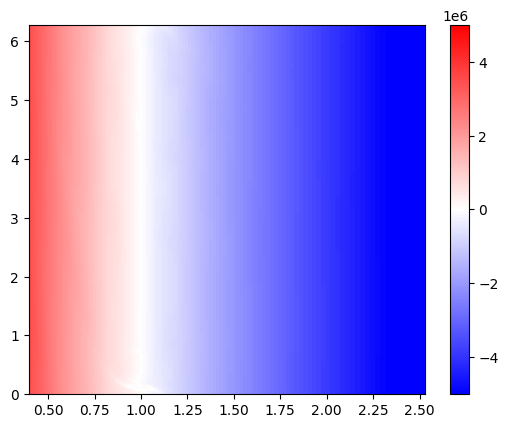

In [49]:
fig, ax = plt.subplots()
Ri, PHIi = l.gas.grid.meshgrid_plot()
vmax = 5e6
pcm = ax.pcolormesh(Ri.to_value('au'), PHIi, vc, cmap="bwr", vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(pcm, ax=ax)

In [58]:
%%prun
# use grid symmetry to interpolate to cell centers
from scipy.interpolate import interp1d
f = interp1d(np.append(PHIa[0,:], [2*np.pi]), np.hstack([va, va[:,0].reshape(-1,1)]), axis=1, kind="cubic")
va_ = f(PHIc[0,:])

         280 function calls in 0.005 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.003    0.003    0.003    0.003 _bsplines.py:1138(make_interp_spline)
        1    0.001    0.001    0.001    0.001 _bsplines.py:511(_evaluate)
        1    0.000    0.000    0.005    0.005 {built-in method builtins.exec}
        5    0.000    0.000    0.000    0.000 {built-in method numpy.ascontiguousarray}
        1    0.000    0.000    0.000    0.000 shape_base.py:292(hstack)
        1    0.000    0.000    0.000    0.000 {method 'take' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.004    0.004 _interpolate.py:490(__init__)
        8    0.000    0.000    0.000    0.000 {built-in method numpy.array}
        1    0.000    0.000    0.005    0.005 <string>:1(<module>)
        7    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    0.000    0.000 {scipy.interp

In [13]:
va_.shape

(148, 504)

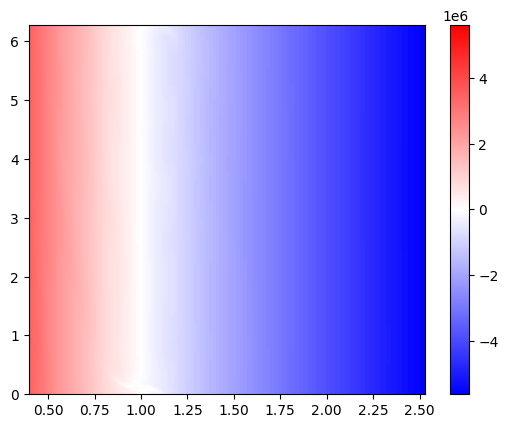

In [43]:
Ri, PHIi = l.gas.grid.meshgrid_plot()
fig, ax = plt.subplots()
vmax = np.max(np.abs(va_))
pcm = ax.pcolormesh(Ri.to_value('au'), PHIi, va_, cmap="bwr", vmin=-vmax, vmax=vmax)
# add colorbar
fig.colorbar(pcm, ax=ax)
pcm

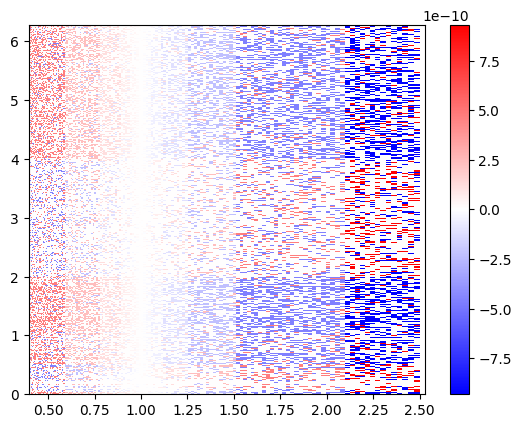

In [15]:
Ri, PHIi = l.gas.grid.meshgrid_plot()
fig, ax = plt.subplots()
pcm = ax.pcolormesh(Ri.to_value('au'), PHIi, va_-vc, cmap="bwr")
# add colorbar
fig.colorbar(pcm, ax=ax)
pcm

## Interpolation in r

In [16]:
%%prun
vr_ = griddata((Rr.ravel(), PHIr.ravel()), vr.ravel(), (Rc, PHIc), method="linear")

         124 function calls in 1.597 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.592    1.592    1.596    1.596 _ndgriddata.py:124(griddata)
        3    0.004    0.001    0.004    0.001 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    0.000    0.000 {built-in method scipy.interpolate.interpnd._ndim_coords_from_arrays}
        1    0.000    0.000    1.597    1.597 <string>:1(<module>)
        1    0.000    0.000    1.597    1.597 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method posix.open}
        1    0.000    0.000    0.000    0.000 tempfile.py:382(_mkstemp_inner)
        2    0.000    0.000    0.000    0.000 stride_tricks.py:416(_broadcast_shape)
        4    0.000    0.000    0.000    0.000 {built-in method numpy.array}
        1    0.000    0.000    0.000    0.000 quantity.py:573(__array_finalize__)
        2    0.000    0.000    

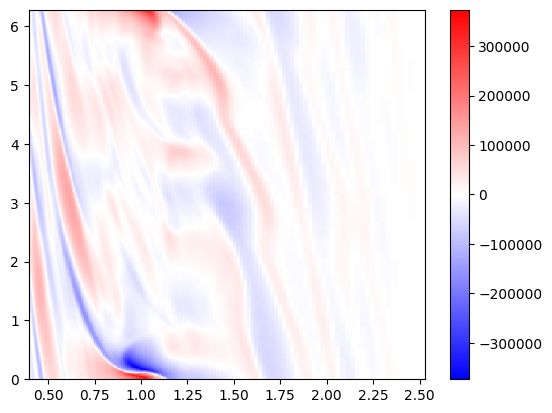

In [42]:
fig, ax = plt.subplots()
Ri, PHIi = l.gas.grid.meshgrid_plot()
vmax = np.max(np.abs(vr_))
pcm = ax.pcolormesh(Ri.to_value('au'), PHIi, vr_, cmap="bwr", vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(pcm, ax=ax)

In [18]:
%%prun
# use grid symmetry to interpolate to cell centers
from scipy.interpolate import interp1d
f = interp1d(Rr[:,0], vr, axis=0, kind="linear")
vr__ = f(Rc[:,0])

         130 function calls (129 primitive calls) in 0.001 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 _interpolate.py:679(_call_linear)
        1    0.000    0.000    0.001    0.001 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 {built-in method numpy.array}
        1    0.000    0.000    0.000    0.000 {method 'take' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 _interpolate.py:490(__init__)
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _util.py:194(_asarray_validated)
        1    0.000    0.000    0.000    0.000 _polyint.py:114(_set_yi)
        1    0.000    0.000    0.000    0.000 _methods.py:90(_clip)
        2    0.000    0.000    0.000    0.000 quantity.py:573(__array_finalize__)
        1    0.000    0.000    0.000    0.000 _interpolate.py:63

In [19]:
vr__.shape

(148, 504)

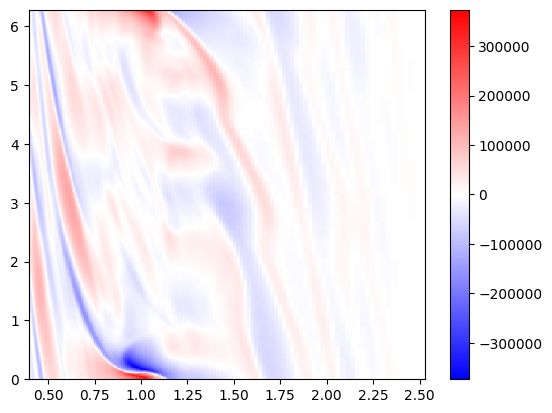

In [41]:
fig, ax = plt.subplots()
Ri, PHIi = l.gas.grid.meshgrid_plot()
vmax = np.max(np.abs(vr__))
pcm = ax.pcolormesh(Ri.to_value('au'), PHIi, vr__, cmap="bwr", vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(pcm, ax=ax)

The difference between both

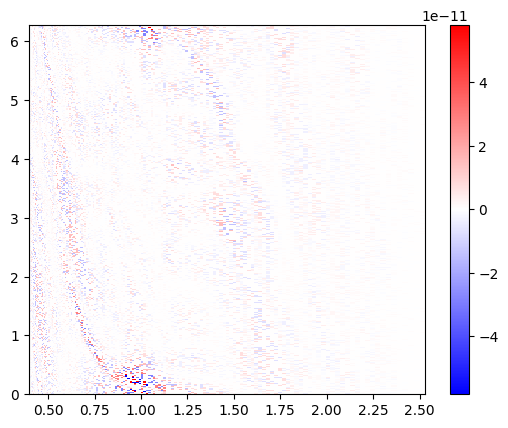

In [21]:
fig, ax = plt.subplots()
Ri, PHIi = l.gas.grid.meshgrid_plot()
pcm = ax.pcolormesh(Ri.to_value('au'), PHIi, vr_-vr__, cmap="bwr")
cbar = fig.colorbar(pcm, ax=ax)

Again, this is 1e-16 below the data range, so it should be numerical noise.

## Interpolation order

Now let's study the effect the interpolation order has.

First, we define functions for interpolation.

In [26]:
from scipy.interpolate import interp1d

def interp_vr(r_data, vr, r_new, kind="linear"):
    f = interp1d(r_data, vr, axis=0, kind=kind)
    vr_ = f(r_new)
    return vr_

def interp_va(phi_data, va, phi_new, kind="linear"):
    phi = np.append(phi_data, [2*np.pi])
    f = interp1d(phi_data, np.hstack([va, va[:,0].reshape(-1,1)]), axis=1, kind=kind)
    va_ = f(phi_new)
    return va_

In [28]:
ri = l.gas.grid.radi.to_value("au")
rc = l.gas.grid.radc.to_value("au")

phii = l.gas.grid.phii
phic = l.gas.grid.phic

va_l = interp_va(phii, va, phic, kind="linear")
va_q = interp_va(phii, va, phic, kind="quadratic")
va_c = interp_va(phii, va, phic, kind="cubic")

vr_l = interp_vr(ri, vr, rc, kind="linear")
vr_q = interp_vr(ri, vr, rc, kind="quadratic")
vr_c = interp_vr(ri, vr, rc, kind="cubic")

Text(0.5, 1.0, 'vr: quadratic - cubic')

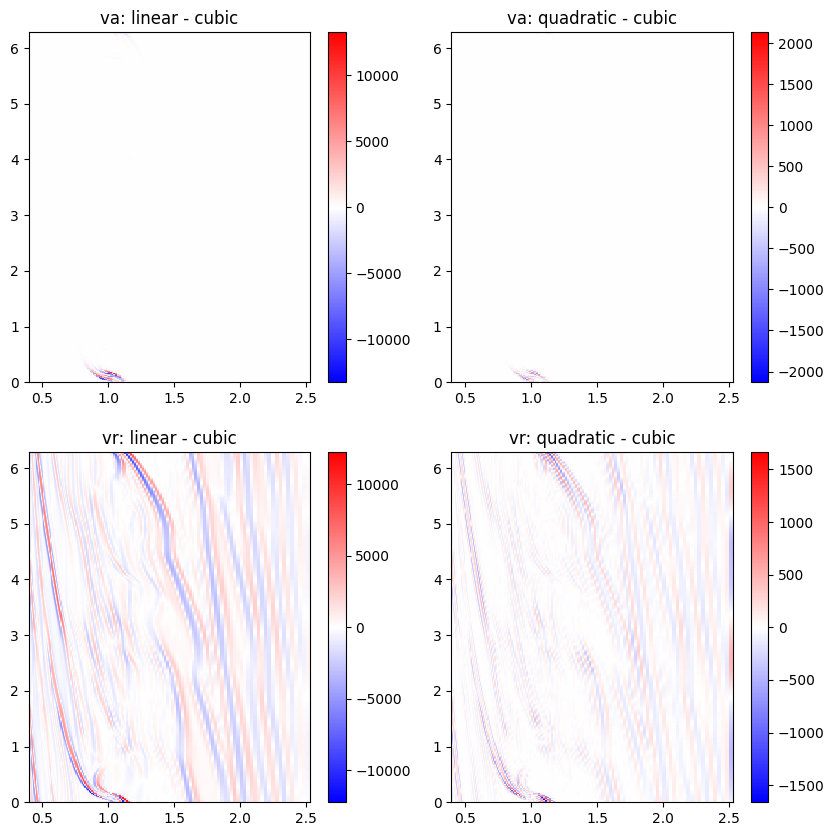

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
Ri, PHIi = l.gas.grid.meshgrid_plot()
d = va_l-va_c
vmax = np.max(np.abs(d))
pcm = axs[0,0].pcolormesh(Ri.to_value('au'), PHIi, d, cmap="bwr", vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(pcm, ax=axs[0,0])
axs[0,0].set_title("va: linear - cubic")
d = va_q-va_c
vmax = np.max(np.abs(d))
pcm = axs[0,1].pcolormesh(Ri.to_value('au'), PHIi, d, cmap="bwr", vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(pcm, ax=axs[0,1])
axs[0,1].set_title("va: quadratic - cubic")

d = vr_l-vr_c
vmax = np.max(np.abs(d))
pcm = axs[1,0].pcolormesh(Ri.to_value('au'), PHIi, d, cmap="bwr", vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(pcm, ax=axs[1,0])
axs[1,0].set_title("vr: linear - cubic")

d = vr_q-vr_c
vmax = np.max(np.abs(d))
pcm = axs[1,1].pcolormesh(Ri.to_value('au'), PHIi, d, cmap="bwr", vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(pcm, ax=axs[1,1])
axs[1,1].set_title("vr: quadratic - cubic")


Clearly, the strongest differences are in the regions of the spirals

Text(0.5, 1.0, 'vr: quadratic/cubic - 1')

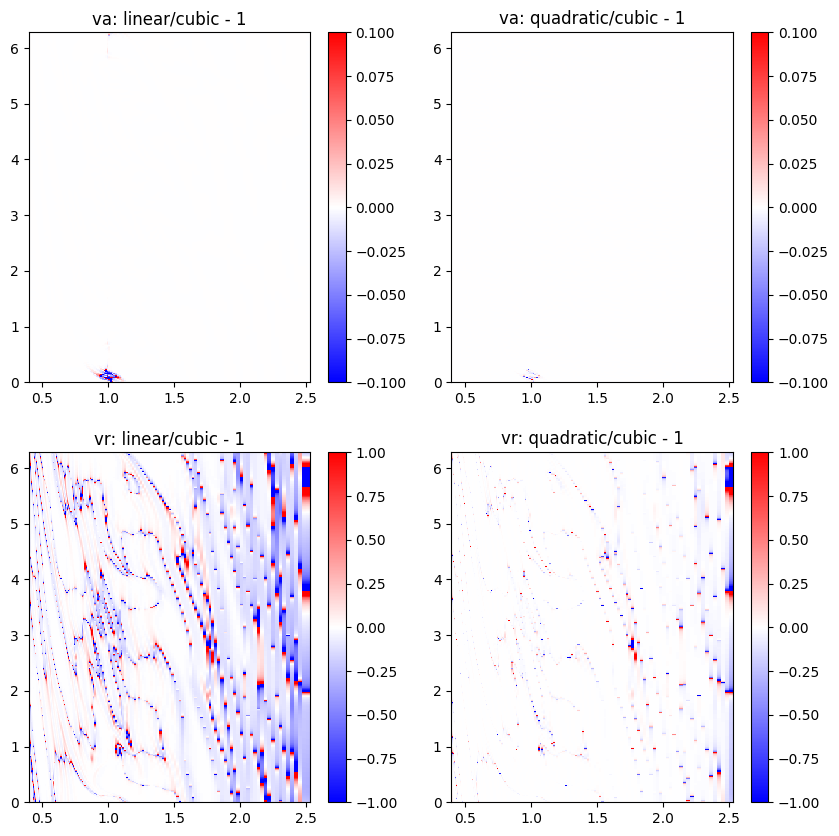

In [50]:
vmax = 1e-1

fig, axs = plt.subplots(2, 2, figsize=(10,10))
Ri, PHIi = l.gas.grid.meshgrid_plot()
d = va_l/va_c - 1
pcm = axs[0,0].pcolormesh(Ri.to_value('au'), PHIi, d, cmap="bwr", vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(pcm, ax=axs[0,0])
axs[0,0].set_title("va: linear/cubic - 1")

d = va_q/va_c - 1
pcm = axs[0,1].pcolormesh(Ri.to_value('au'), PHIi, d, cmap="bwr", vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(pcm, ax=axs[0,1])
axs[0,1].set_title("va: quadratic/cubic - 1")

vmax = 1

d = vr_l/vr_c - 1
pcm = axs[1,0].pcolormesh(Ri.to_value('au'), PHIi, d, cmap="bwr", vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(pcm, ax=axs[1,0])
axs[1,0].set_title("vr: linear/cubic - 1")

d = vr_q/vr_c - 1
pcm = axs[1,1].pcolormesh(Ri.to_value('au'), PHIi, d, cmap="bwr", vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(pcm, ax=axs[1,1])
axs[1,1].set_title("vr: quadratic/cubic - 1")
